In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras import metrics

#data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)
data = pd.read_csv('/Users/alket/Desktop/dati/new_data_Modena_backfill_forwfill.csv',index_col = 0)
# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])

In [3]:
num_data = []
## prepare dataset
for i, k in agg_by_cell:
    cell_i = agg_by_cell.get_group(i)
    # define input sequence
    series_i = cell_i['nr_people'].values
    series_i = series_i.reshape((len(series_i), 1))
    num_data.append(series_i)

In [4]:
final_data = hstack((num_data))
final_data.shape

(11808, 1353)

In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the dataset
      if out_end_ix > len(sequences):
          break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 8, 8

# convert into input/output
X, y = split_sequences(final_data, n_steps_in, n_steps_out)

count = 0
for i in range(len(X)):
    count += 1
    print('inizia iterazione ', i)
    print(X[i], y[i])
    if count > 1: break
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

inizia iterazione  0
[[361. 188. 336. ...  63.  57.  23.]
 [367. 191. 337. ...  65.  59.  24.]
 [359. 186. 335. ...  65.  59.  24.]
 ...
 [343. 178. 316. ...  65.  58.  24.]
 [346. 179. 317. ...  65.  58.  24.]
 [344. 179. 316. ...  64.  58.  23.]] [[339. 177. 314. ...  64.  57.  23.]
 [335. 175. 312. ...  64.  58.  23.]
 [336. 175. 310. ...  64.  58.  23.]
 ...
 [333. 173. 307. ...  63.  57.  23.]
 [331. 173. 307. ...  63.  57.  23.]
 [329. 172. 307. ...  63.  57.  23.]]
inizia iterazione  1
[[367. 191. 337. ...  65.  59.  24.]
 [359. 186. 335. ...  65.  59.  24.]
 [354. 185. 332. ...  65.  59.  24.]
 ...
 [346. 179. 317. ...  65.  58.  24.]
 [344. 179. 316. ...  64.  58.  23.]
 [339. 177. 314. ...  64.  57.  23.]] [[335. 175. 312. ...  64.  58.  23.]
 [336. 175. 310. ...  64.  58.  23.]
 [334. 174. 309. ...  64.  58.  23.]
 ...
 [331. 173. 307. ...  63.  57.  23.]
 [329. 172. 307. ...  63.  57.  23.]
 [329. 172. 307. ...  63.  57.  23.]]


In [6]:
split_train_test = int(len(X)*0.75)
train_X, test_X = X[:split_train_test], X[split_train_test:]
train_y, test_y = y[:split_train_test], y[split_train_test:]
print(len(train_X), len(train_y), len(test_X), len(test_y))

8838 8838 2947 2947


In [7]:
final_data.shape

(11808, 1353)

In [8]:
# define model
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=n_input)) 
model.add(Dense(250, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse',  metrics=[metrics.mae, 'accuracy'])

# fit model
model.fit(train_X, train_y, epochs=100, verbose=2)

Epoch 1/100
 - 40s - loss: 41601.2444 - mean_absolute_error: 62.8788 - accuracy: 0.0733
Epoch 2/100
 - 41s - loss: 14649.4196 - mean_absolute_error: 39.7537 - accuracy: 0.1156
Epoch 3/100
 - 41s - loss: 9220.0793 - mean_absolute_error: 29.7836 - accuracy: 0.1139
Epoch 4/100
 - 43s - loss: 17285.4033 - mean_absolute_error: 39.2320 - accuracy: 0.0802
Epoch 5/100
 - 41s - loss: 6765.0924 - mean_absolute_error: 26.9149 - accuracy: 0.1328
Epoch 6/100
 - 42s - loss: 7548.5531 - mean_absolute_error: 25.7146 - accuracy: 0.1107
Epoch 7/100
 - 41s - loss: 6686.3463 - mean_absolute_error: 26.6108 - accuracy: 0.1025
Epoch 8/100
 - 43s - loss: 8888.6146 - mean_absolute_error: 29.6293 - accuracy: 0.1127
Epoch 9/100
 - 42s - loss: 7297.7894 - mean_absolute_error: 26.8750 - accuracy: 0.1129
Epoch 10/100
 - 43s - loss: 8280.9683 - mean_absolute_error: 28.2456 - accuracy: 0.1189
Epoch 11/100
 - 42s - loss: 6347.6458 - mean_absolute_error: 23.8985 - accuracy: 0.1231
Epoch 12/100
 - 41s - loss: 6319.1017 

KeyboardInterrupt: 

In [ ]:
predicted = np.array([])
for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0])

print(len(test_y))
var4diff2 = len(test_y)
print('shape ',test_y.shape )
exp_y = test_y.reshape((test_y.shape[0] * test_y.shape[1]))    
expected = exp_y    
print(len(expected))
print(len(predicted))

In [ ]:
difference = abs(predicted - expected)
print('Mean Absolute Error = ', np.mean(difference))
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert = False)
plt.show()

In [ ]:
shape_i = final_data.shape[1] * n_steps_out 
print(shape_i)

difference2 = difference.reshape( var4diff2, shape_i)
print(difference2.shape)

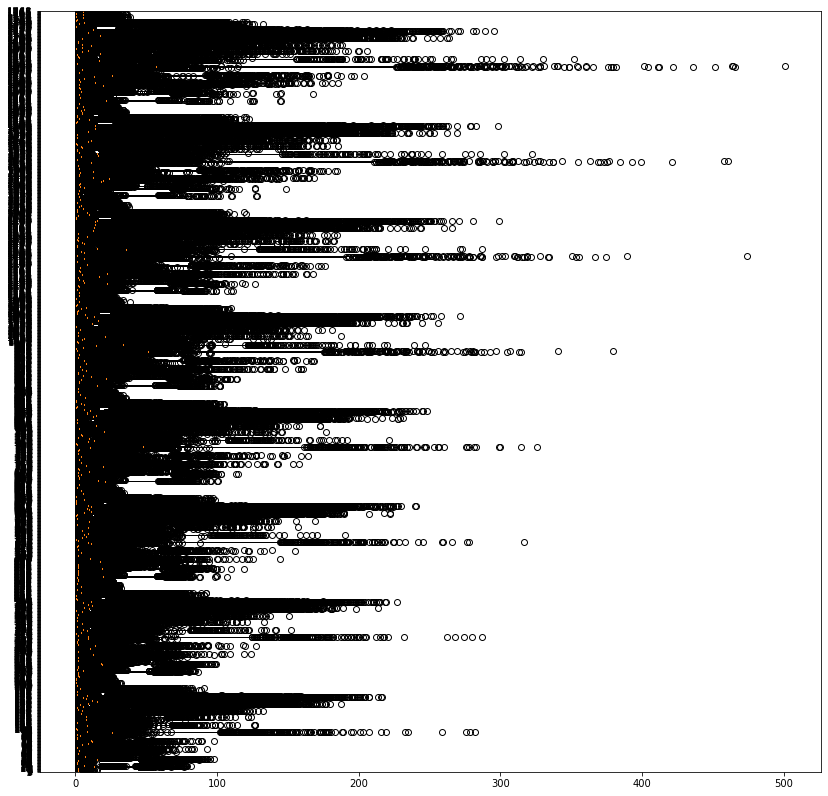

In [14]:
plt.figure(figsize = (14,14))
plt.boxplot(difference2, vert = False)
plt.show()